<a href="https://colab.research.google.com/github/mkuczynski11/pug-project/blob/main/PUG_Optymized_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [24]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

### Tensorboard and HParams setup

In [25]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
# # Clear any logs from previous runs
# !rm -rf /content/gdrive/MyDrive/PUG/opt_logs

In [27]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

### Setup training and validation datasets

In [28]:
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50
DENSE_LAYER_ACTIVATION = 'softmax'
CLASS_MODE='categorical'
OBJECTIVE_FUNCTION='categorical_crossentropy'
LOSS_METRICS=['accuracy']
EARLY_STOP_PATIENCE = 3
STEPS_PER_EPOCH_TRAINING = 10

In [29]:
# Usage of google drive where we are storing our data
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/PUG/garbage_classification' # directory of your data
!rm -rf /content/gdrive/MyDrive/PUG/garbage_classification/.ipynb_checkpoints/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_128 = ImageDataGenerator(
    validation_split=0.2
)

In [31]:
train_ds_128 = data_generator_128.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE,
    subset='training'
)

Found 12415 images belonging to 12 classes.


In [32]:
val_ds_128 = data_generator_128.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode=CLASS_MODE,
    subset='validation'
)

Found 3100 images belonging to 12 classes.


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_224 = ImageDataGenerator(
    validation_split=0.2
)

In [34]:
train_ds_224 = data_generator_224.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE,
    subset='training'
)

Found 12415 images belonging to 12 classes.


In [35]:
val_ds_224 = data_generator_224.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode=CLASS_MODE,
    subset='validation'
)

Found 3100 images belonging to 12 classes.


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_480 = ImageDataGenerator(
    validation_split=0.2
)

In [37]:
train_ds_480 = data_generator_480.flow_from_directory(
    data_dir,
    target_size=(480, 480),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE,
    subset='training'
)

Found 12415 images belonging to 12 classes.


In [38]:
val_ds_480 = data_generator_480.flow_from_directory(
    data_dir,
    target_size=(480, 480),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode=CLASS_MODE,
    subset='validation'
)

Found 3100 images belonging to 12 classes.


In [39]:
class_names = []
for key in train_ds_224.class_indices.keys():
  class_names.append(key)

print(class_names)


['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


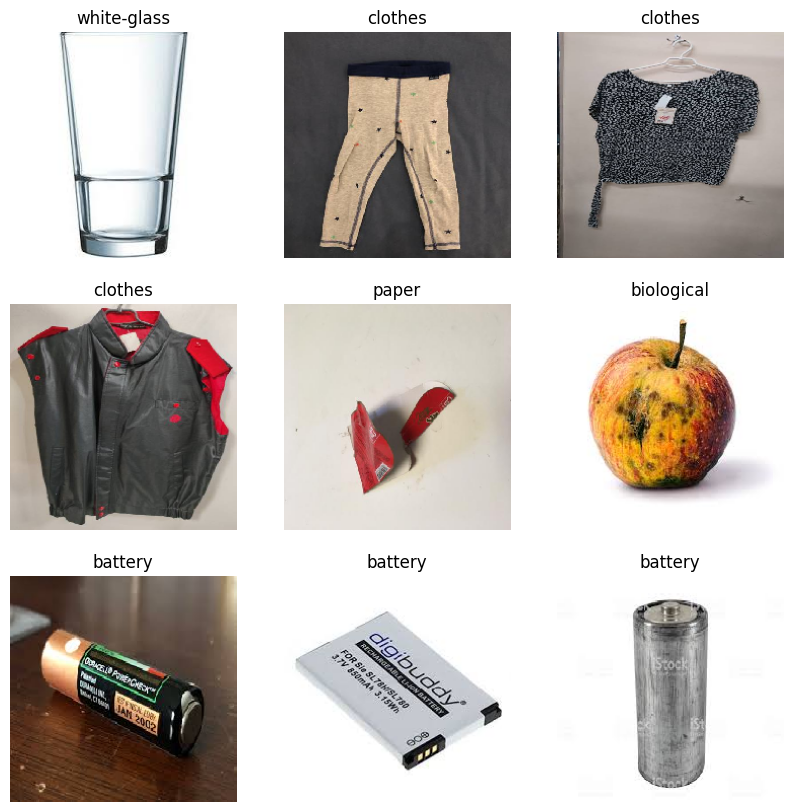

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(train_ds_224[0][0][i].astype('uint8'))
  index = np.argmax(train_ds_224[0][1][i])
  plt.title(class_names[index])
  plt.axis("off")

### Define model and training function

In [42]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))
HP_CNN = hp.HParam('cnn', hp.Discrete(["https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/5", "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5", "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-m-feature-vector/versions/2"]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer(f'/content/gdrive/MyDrive/PUG/fix_logs_3/hparam_tuning').as_default():
  hp.hparams_config(
    # hparams=[HP_NUM_UNITS, HP_CNN, HP_DROPOUT],
    hparams=[HP_NUM_UNITS, HP_CNN],
    metrics=[hp.Metric('epoch_accuracy')],
  )

In [44]:
cnn_params = {
    "https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/5": {
        "train_ds": train_ds_128,
        "val_ds": val_ds_128,
    },
    "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5": {
        "train_ds": train_ds_224,
        "val_ds": val_ds_224,
    },
    "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-m-feature-vector/versions/2": {
        "train_ds": train_ds_480,
        "val_ds": val_ds_480,
    },
}

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE
)

In [46]:
import tensorflow_hub as hub
from tensorflow.keras import optimizers

def train_test_model(run_dir, hparams):
  # base_model_path = f'/content/gdrive/MyDrive/PUG/fix_models_3/best_model:{hparams[HP_NUM_UNITS]}:{hparams[HP_CNN]}:{hparams[HP_DROPOUT]}.h5'
  base_model_path = f'/content/gdrive/MyDrive/PUG/fix_models_3/best_model:{hparams[HP_NUM_UNITS]}:{hparams[HP_CNN]}:0.2.h5'

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      base_model_path,
      save_best_only=True
  )


  num_classes = cnn_params[hparams[HP_CNN]]["train_ds"].num_classes

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Rescaling(1./255))
  model.add(hub.KerasLayer(hparams[HP_CNN], trainable=False))
  model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.Dense(96, activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(num_classes, activation=DENSE_LAYER_ACTIVATION))

  model.compile(optimizer='adam',
              loss=OBJECTIVE_FUNCTION,
              metrics=LOSS_METRICS)

  model.fit(
    cnn_params[hparams[HP_CNN]]["train_ds"],
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=cnn_params[hparams[HP_CNN]]["val_ds"],
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.TensorBoard(run_dir, histogram_freq=1), hp.KerasCallback(run_dir, hparams)]
  )

  # # Also add epochs that model has been trained on
  # import sys
  # original_stdout = sys.stdout # Save a reference to the original standard output
  # with open(f'/content/gdrive/MyDrive/PUG/opt_models_2/best_model:{hparams[HP_NUM_UNITS]}:{hparams[HP_CNN]}:{hparams[HP_DROPOUT]}.txt', 'w') as f:
  #     sys.stdout = f # Change the standard output to the file we created.
  #     model.summary()
  #     sys.stdout = original_stdout # Reset the standard output to its original value
  loss, acc = model.evaluate(cnn_params[hparams[HP_CNN]]["val_ds"])
  return loss, acc

### Train model

In [47]:
session_num = 3

for num_units in HP_NUM_UNITS.domain.values:
  # for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
  for cnn in HP_CNN.domain.values:
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_CNN: cnn,
        # HP_DROPOUT: dropout_rate,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    train_test_model('/content/gdrive/MyDrive/PUG/opt_logs_3/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-3
{'num_units': 64, 'cnn': 'https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/5'}
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.9395 - accuracy: 0.4120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 20s 2s/step - loss: 1.9395 - accuracy: 0.4120 - val_loss: 1.2808 - val_accuracy: 0.6287
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.8128 - accuracy: 0.7820 - val_loss: 0.8054 - val_accuracy: 0.7652
Epoch 3/100
10/10 [==============================] - 15s 2s/step - loss: 0.5263 - accuracy: 0.8600 - val_loss: 0.6743 - val_accuracy: 0.8016
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.4852 - accuracy: 0.8645 - val_loss: 0.5913 - val_accuracy: 0.8252
Epoch 5/100
10/10 [==============================] - 14s 2s/step - loss: 0.3604 - accuracy: 0.9090 - val_loss: 0.5346 - val_accuracy: 0.8368
Epoch 6/100
10/10 [==============================] - 15s 2s/step - loss: 0.3455 - accuracy: 0.9070 - val_loss: 0.4756 - val_accuracy: 0.8484
Epoch 7/100
10/10 [==============================] - 15s 2s/step - loss: 0.2787 - accuracy: 0.9360 - val_loss: 0.4331 - val_accuracy: 0.8626
Epoch 8/100
10/10 [======

In [ ]:
%tensorboard --logdir /content/gdrive/MyDrive/PUG/opt_logs_3/hparam_tuning/